In [257]:
import os, sys
sys.path.append('../src/')

from copulae1 import *

import json
with open('../src/configs/BBT_future_Tiingo_xrp_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [258]:
OHR = pd.read_csv("../results/%s/%s/OHR.csv"%(data_name, calibration_method))
cleaned_data = pd.read_csv('../data/cleaned_data/BBT_future_Tiingo_xrp.csv')

In [259]:
def numerical_search(rs, rf):
    h_arr = np.linspace(0,2,2001)

    ERM_arr = []
    ES1_arr = []
    ES5_arr = []
    VaR1_arr = []
    VaR5_arr = []
    Var_arr = []

    for h in h_arr:
        rh = rs - h*rf
        ERM_arr.append(ERM_estimate_trapezoidal(10, rh))
        ES1_arr.append(ES(0.01,rh))
        ES5_arr.append(ES(0.05,rh))
        VaR1_arr.append(VaR(0.01,rh))
        VaR5_arr.append(VaR(0.05,rh))
        Var_arr.append(Variance(rh))
        
    return (h_arr[np.argmin(ERM_arr)], h_arr[np.argmin(ES1_arr)],
            h_arr[np.argmin(ES5_arr)], h_arr[np.argmin(VaR1_arr)],
            h_arr[np.argmin(VaR5_arr)], h_arr[np.argmin(Var_arr)])

In [260]:
numerical_search(rs, rf)

(1.118, 0.8260000000000001, 1.274, 1.665, 0.984, 1.193)

In [261]:
risk_measures_names = list(np.unique(OHR.loc[:,'risk measure']))

In [262]:
files = os.listdir('../processed_data/%s/train/'%data_name)
len(files)

112

In [263]:
for f in range(len(files)):
    train = pd.read_csv('../processed_data/%s/train/%s.csv'%(data_name, str(f)))
    rs = train.loc[:,config['spot_name']]
    rf = train.loc[:,config['future_name']]
    a = pd.DataFrame({'OHR':numerical_search(rs, rf), 'copula':'numerical', 'file':str(f)+'.csv',
                  'risk measure':risk_measures_names})
    
    OHR = OHR.append(a, ignore_index=True)
    print(f)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [264]:
def hedging_effectiveness2(rm, rs, rf, h):
    rh = rs - h*rf
    if rm == 'ERM k=10':
        return(1-ERM_estimate_trapezoidal(10, rh)/ERM_estimate_trapezoidal(10, rs))

    elif rm == 'ES q=0.01':
        return(1-ES(0.01, rh)/ES(0.01, rs))

    elif rm == 'ES q=0.05':
        return(1-ES(0.05, rh)/ES(0.05, rs))

    elif rm == 'VaR q=0.01':
        return(1-VaR(0.01, rh)/VaR(0.01, rs))

    elif rm == 'VaR q=0.05':
        return(1-VaR(0.05, rh)/VaR(0.05, rs))

    elif rm == 'Variance':
        return(1-Variance(rh)/Variance(rs))
    
    
def rename_rm(rm):
    rm = rm.replace('q=','')
    rm = rm.replace('0.01', '99%')
    rm = rm.replace('0.05', '95%')
    return rm

In [265]:
OHR.loc[:,'file_number'] = OHR.loc[:,'file'].apply(lambda x: int(x.replace('.csv', '')))

In [266]:
OHR

,Unnamed: 0,file,risk measure,OHR,copula,file_number
0,0.0,97.csv,Variance,1.165820,Gaussian,97
1,1.0,97.csv,ERM k=10,1.054199,Gaussian,97
2,2.0,97.csv,ES q=0.01,1.065234,Gaussian,97
3,3.0,97.csv,ES q=0.05,1.075293,Gaussian,97
4,4.0,97.csv,VaR q=0.01,1.081250,Gaussian,97
...,...,...,...,...,...,...
6043,NaN,111.csv,ES q=0.01,0.826000,numerical,111
6044,NaN,111.csv,ES q=0.05,1.274000,numerical,111
6045,NaN,111.csv,VaR q=0.01,1.665000,numerical,111
6046,NaN,111.csv,VaR q=0.05,0.984000,numerical,111


In [267]:
days = 100

In [268]:
c_arr = []
rm_arr = []
HE_arr = []

for index, row in OHR.iterrows():
    train = pd.read_csv('../processed_data/%s/train/%s.csv'%(data_name, row.loc['file_number']))
    _id = cleaned_data.loc[cleaned_data.Date == train.Date.iloc[0],:].index[0]

    if _id-days <0:
        print(index, 'is skipped')
        continue

    test = cleaned_data.iloc[_id-days:_id,:]
    rs = test.loc[:,config['spot_name']]
    rf = test.loc[:,config['future_name']]

    rm  = row.loc['risk measure']
    c = row.loc['copula']
    h = row.loc['OHR']

    rm_arr.append(rm)
    c_arr.append(c)
    HE_arr.append(hedging_effectiveness2(rm, rs, rf, h))
    print(index, 'is done')


0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is skipped
19 is skipped
20 is skipped
21 is skipped
22 is skipped
23 is skipped
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
35 is done
36 is done
37 is done
38 is done
39 is done
40 is done
41 is done
42 is skipped
43 is skipped
44 is skipped
45 is skipped
46 is skipped
47 is skipped
48 is done
49 is done
50 is done
51 is done
52 is done
53 is done
54 is done
55 is done
56 is done
57 is done
58 is done
59 is done
60 is done
61 is done
62 is done
63 is done
64 is done
65 is done
66 is done
67 is done
68 is done
69 is done
70 is done
71 is done
72 is done
73 is done
74 is done
75 is done
76 is done
77 is done
78 is done
79 is done
80 is done
81 is done
82 is done
83 is done
84 is done
85 is done
86 is done
87 is done
88 is 

671 is done
672 is done
673 is done
674 is done
675 is done
676 is done
677 is done
678 is done
679 is done
680 is done
681 is done
682 is done
683 is done
684 is done
685 is done
686 is done
687 is done
688 is done
689 is done
690 is skipped
691 is skipped
692 is skipped
693 is skipped
694 is skipped
695 is skipped
696 is done
697 is done
698 is done
699 is done
700 is done
701 is done
702 is done
703 is done
704 is done
705 is done
706 is done
707 is done
708 is done
709 is done
710 is done
711 is done
712 is done
713 is done
714 is skipped
715 is skipped
716 is skipped
717 is skipped
718 is skipped
719 is skipped
720 is done
721 is done
722 is done
723 is done
724 is done
725 is done
726 is done
727 is done
728 is done
729 is done
730 is done
731 is done
732 is done
733 is done
734 is done
735 is done
736 is done
737 is done
738 is done
739 is done
740 is done
741 is done
742 is done
743 is done
744 is done
745 is done
746 is done
747 is done
748 is done
749 is done
750 is done
751 

1311 is done
1312 is done
1313 is done
1314 is done
1315 is done
1316 is done
1317 is done
1318 is done
1319 is done
1320 is done
1321 is done
1322 is done
1323 is done
1324 is done
1325 is done
1326 is done
1327 is done
1328 is done
1329 is done
1330 is done
1331 is done
1332 is done
1333 is done
1334 is done
1335 is done
1336 is done
1337 is done
1338 is done
1339 is done
1340 is done
1341 is done
1342 is done
1343 is done
1344 is done
1345 is done
1346 is done
1347 is done
1348 is done
1349 is done
1350 is done
1351 is done
1352 is done
1353 is done
1354 is done
1355 is done
1356 is done
1357 is done
1358 is done
1359 is done
1360 is done
1361 is done
1362 is skipped
1363 is skipped
1364 is skipped
1365 is skipped
1366 is skipped
1367 is skipped
1368 is done
1369 is done
1370 is done
1371 is done
1372 is done
1373 is done
1374 is done
1375 is done
1376 is done
1377 is done
1378 is done
1379 is done
1380 is done
1381 is done
1382 is done
1383 is done
1384 is done
1385 is done
1386 is

1925 is done
1926 is done
1927 is done
1928 is done
1929 is done
1930 is done
1931 is done
1932 is done
1933 is done
1934 is done
1935 is done
1936 is done
1937 is done
1938 is done
1939 is done
1940 is done
1941 is done
1942 is done
1943 is done
1944 is done
1945 is done
1946 is done
1947 is done
1948 is done
1949 is done
1950 is skipped
1951 is skipped
1952 is skipped
1953 is skipped
1954 is skipped
1955 is skipped
1956 is skipped
1957 is skipped
1958 is skipped
1959 is skipped
1960 is skipped
1961 is skipped
1962 is done
1963 is done
1964 is done
1965 is done
1966 is done
1967 is done
1968 is done
1969 is done
1970 is done
1971 is done
1972 is done
1973 is done
1974 is done
1975 is done
1976 is done
1977 is done
1978 is done
1979 is done
1980 is done
1981 is done
1982 is done
1983 is done
1984 is done
1985 is done
1986 is done
1987 is done
1988 is done
1989 is done
1990 is done
1991 is done
1992 is done
1993 is done
1994 is done
1995 is done
1996 is done
1997 is done
1998 is done
19

2549 is done
2550 is done
2551 is done
2552 is done
2553 is done
2554 is done
2555 is done
2556 is done
2557 is done
2558 is done
2559 is done
2560 is done
2561 is done
2562 is done
2563 is done
2564 is done
2565 is done
2566 is done
2567 is done
2568 is done
2569 is done
2570 is done
2571 is done
2572 is done
2573 is done
2574 is done
2575 is done
2576 is done
2577 is done
2578 is done
2579 is done
2580 is done
2581 is done
2582 is done
2583 is done
2584 is done
2585 is done
2586 is done
2587 is done
2588 is done
2589 is done
2590 is done
2591 is done
2592 is done
2593 is done
2594 is done
2595 is done
2596 is done
2597 is done
2598 is done
2599 is done
2600 is done
2601 is done
2602 is done
2603 is done
2604 is done
2605 is done
2606 is done
2607 is done
2608 is done
2609 is done
2610 is done
2611 is done
2612 is done
2613 is done
2614 is done
2615 is done
2616 is done
2617 is done
2618 is done
2619 is done
2620 is done
2621 is done
2622 is skipped
2623 is skipped
2624 is skipped
262

3177 is done
3178 is done
3179 is done
3180 is done
3181 is done
3182 is done
3183 is done
3184 is done
3185 is done
3186 is skipped
3187 is skipped
3188 is skipped
3189 is skipped
3190 is skipped
3191 is skipped
3192 is skipped
3193 is skipped
3194 is skipped
3195 is skipped
3196 is skipped
3197 is skipped
3198 is done
3199 is done
3200 is done
3201 is done
3202 is done
3203 is done
3204 is done
3205 is done
3206 is done
3207 is done
3208 is done
3209 is done
3210 is done
3211 is done
3212 is done
3213 is done
3214 is done
3215 is done
3216 is done
3217 is done
3218 is done
3219 is done
3220 is done
3221 is done
3222 is done
3223 is done
3224 is done
3225 is done
3226 is done
3227 is done
3228 is done
3229 is done
3230 is done
3231 is done
3232 is done
3233 is done
3234 is done
3235 is done
3236 is done
3237 is done
3238 is done
3239 is done
3240 is done
3241 is done
3242 is done
3243 is done
3244 is done
3245 is done
3246 is done
3247 is done
3248 is done
3249 is done
3250 is done
32

3802 is done
3803 is done
3804 is done
3805 is done
3806 is done
3807 is done
3808 is done
3809 is done
3810 is done
3811 is done
3812 is done
3813 is done
3814 is done
3815 is done
3816 is skipped
3817 is skipped
3818 is skipped
3819 is skipped
3820 is skipped
3821 is skipped
3822 is done
3823 is done
3824 is done
3825 is done
3826 is done
3827 is done
3828 is done
3829 is done
3830 is done
3831 is done
3832 is done
3833 is done
3834 is skipped
3835 is skipped
3836 is skipped
3837 is skipped
3838 is skipped
3839 is skipped
3840 is done
3841 is done
3842 is done
3843 is done
3844 is done
3845 is done
3846 is done
3847 is done
3848 is done
3849 is done
3850 is done
3851 is done
3852 is done
3853 is done
3854 is done
3855 is done
3856 is done
3857 is done
3858 is skipped
3859 is skipped
3860 is skipped
3861 is skipped
3862 is skipped
3863 is skipped
3864 is skipped
3865 is skipped
3866 is skipped
3867 is skipped
3868 is skipped
3869 is skipped
3870 is done
3871 is done
3872 is done
3873 

4430 is skipped
4431 is skipped
4432 is skipped
4433 is skipped
4434 is done
4435 is done
4436 is done
4437 is done
4438 is done
4439 is done
4440 is done
4441 is done
4442 is done
4443 is done
4444 is done
4445 is done
4446 is done
4447 is done
4448 is done
4449 is done
4450 is done
4451 is done
4452 is skipped
4453 is skipped
4454 is skipped
4455 is skipped
4456 is skipped
4457 is skipped
4458 is skipped
4459 is skipped
4460 is skipped
4461 is skipped
4462 is skipped
4463 is skipped
4464 is done
4465 is done
4466 is done
4467 is done
4468 is done
4469 is done
4470 is done
4471 is done
4472 is done
4473 is done
4474 is done
4475 is done
4476 is done
4477 is done
4478 is done
4479 is done
4480 is done
4481 is done
4482 is done
4483 is done
4484 is done
4485 is done
4486 is done
4487 is done
4488 is skipped
4489 is skipped
4490 is skipped
4491 is skipped
4492 is skipped
4493 is skipped
4494 is done
4495 is done
4496 is done
4497 is done
4498 is done
4499 is done
4500 is done
4501 is don

5062 is done
5063 is done
5064 is done
5065 is done
5066 is done
5067 is done
5068 is done
5069 is done
5070 is done
5071 is done
5072 is done
5073 is done
5074 is done
5075 is done
5076 is done
5077 is done
5078 is done
5079 is done
5080 is done
5081 is done
5082 is done
5083 is done
5084 is done
5085 is done
5086 is done
5087 is done
5088 is done
5089 is done
5090 is done
5091 is done
5092 is done
5093 is done
5094 is skipped
5095 is skipped
5096 is skipped
5097 is skipped
5098 is skipped
5099 is skipped
5100 is skipped
5101 is skipped
5102 is skipped
5103 is skipped
5104 is skipped
5105 is skipped
5106 is done
5107 is done
5108 is done
5109 is done
5110 is done
5111 is done
5112 is done
5113 is done
5114 is done
5115 is done
5116 is done
5117 is done
5118 is done
5119 is done
5120 is done
5121 is done
5122 is done
5123 is done
5124 is skipped
5125 is skipped
5126 is skipped
5127 is skipped
5128 is skipped
5129 is skipped
5130 is skipped
5131 is skipped
5132 is skipped
5133 is skippe

5660 is done
5661 is done
5662 is done
5663 is done
5664 is done
5665 is done
5666 is done
5667 is done
5668 is done
5669 is done
5670 is done
5671 is done
5672 is done
5673 is done
5674 is done
5675 is done
5676 is done
5677 is done
5678 is done
5679 is done
5680 is done
5681 is done
5682 is done
5683 is done
5684 is done
5685 is done
5686 is done
5687 is done
5688 is done
5689 is done
5690 is done
5691 is done
5692 is done
5693 is done
5694 is done
5695 is done
5696 is done
5697 is done
5698 is done
5699 is done
5700 is done
5701 is done
5702 is done
5703 is done
5704 is done
5705 is done
5706 is done
5707 is done
5708 is done
5709 is done
5710 is done
5711 is done
5712 is done
5713 is done
5714 is done
5715 is done
5716 is done
5717 is done
5718 is done
5719 is done
5720 is done
5721 is done
5722 is done
5723 is done
5724 is done
5725 is done
5726 is done
5727 is done
5728 is done
5729 is done
5730 is done
5731 is done
5732 is done
5733 is done
5734 is done
5735 is done
5736 is done

In [269]:
HEs = pd.DataFrame({'copula':c_arr, 'risk measure':rm_arr, 'HE':HE_arr})

In [270]:
# Copula_names = np.unique(HEs.copula)
Copula_names = ['Gaussian', 't_Copula', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copula_names += ['numerical']
# risk_measures = np.unique(HEs.loc[:,'risk measure'])

In [271]:
HEs

,copula,risk measure,HE
0,Gaussian,Variance,-0.374891
1,Gaussian,ERM k=10,0.037395
2,Gaussian,ES q=0.01,-0.045922
3,Gaussian,ES q=0.05,0.079192
4,Gaussian,VaR q=0.01,0.274838
...,...,...,...
5017,numerical,ES q=0.01,0.213618
5018,numerical,ES q=0.05,-0.176218
5019,numerical,VaR q=0.01,-1.134537
5020,numerical,VaR q=0.05,0.318111


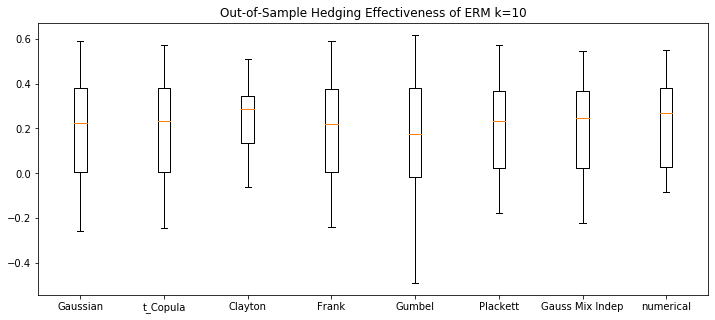

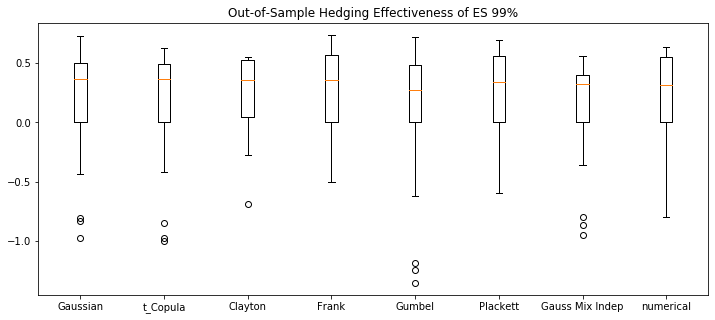

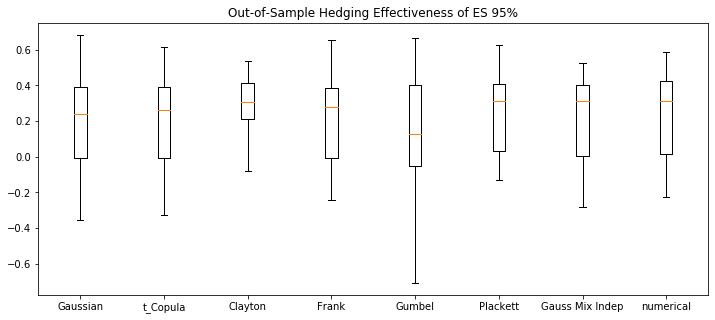

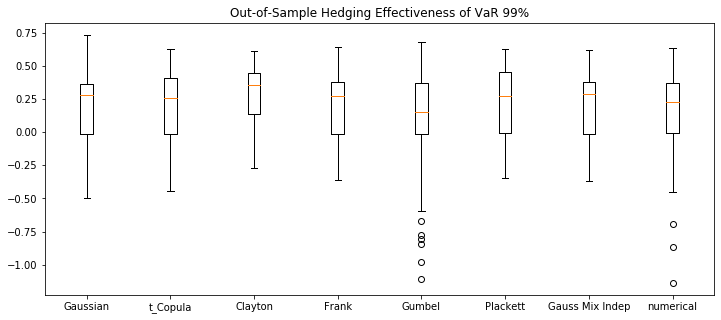

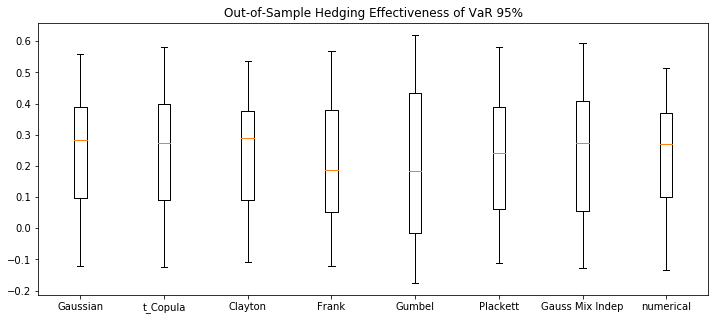

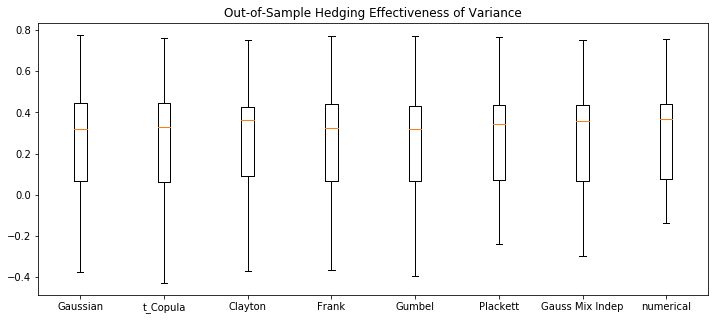

In [273]:
# path = '../latex/_pics/CRIX_future_hedging_effectiveness_100days_with_v3_OHR_with_naive/'
for rm in risk_measures_names:
    i_id = HEs.loc[:,'risk measure'] == rm
    plt.figure(figsize=(12,5))   
    plt.title('Out-of-Sample Hedging Effectiveness of %s' %rename_rm(rm))

    for j, c in enumerate(Copula_names):
        j_id = HEs.copula == c
        plt.boxplot(HEs.loc[i_id&j_id,'HE'], positions=[j])
        
    plt.xticks(range(len(Copula_names)), Copula_names)  
    
# plt.savefig()

In [ ]:
OHR.loc[OHR.file == '97.csv',:]